# Part 1 : River


In [148]:
from river import preprocessing, datasets, linear_model, metrics, cluster, anomaly
import time
from river.forest import ARFClassifier as ARF
import numpy as np

### 1. Supervised Learning with Dataset ELEC2:

In [149]:
data = datasets.Elec2()
models = {
    "Logistic Regression": linear_model.LogisticRegression(),
    "Adaptive Random Forest": ARF(n_models=5, max_depth=10)
}

enc = preprocessing.OneHotEncoder()   
scaler = preprocessing.StandardScaler()  
acc = {name: metrics.Accuracy() for name in models}
prec = {name: metrics.Precision() for name in models}
rec = {name: metrics.Recall() for name in models}
f1 = {name: metrics.F1() for name in models}
mcc = {name: metrics.MCC() for name in models}
kappa = {name: metrics.CohenKappa() for name in models}
roc = {name: metrics.ROCAUC() for name in models}
MAX_SAMPLES = 5000
PRINT_EVERY = 100

n = 0
t0 = time.time()
for x, y in data:
    n += 1
    z = enc.transform_one(x)
    z = scaler.transform_one(z)

    for name, model in models.items():
        y_pred = model.predict_one(z)
        acc[name].update(y, y_pred)
        acc[name].update(y, y_pred)
        prec[name].update(y, y_pred)
        rec[name].update(y, y_pred)
        f1[name].update(y, y_pred)
        mcc[name].update(y, y_pred)
        kappa[name].update(y, y_pred)
        if name in roc and hasattr(model, "predict_proba_one"):
            proba = model.predict_proba_one(z).get(True, 0.0)
            roc[name].update(y, proba)

        model.learn_one(z, y)

    enc.learn_one(x)
    scaler.learn_one(z)

    if n % PRINT_EVERY == 0:
        dt = time.time() - t0
        print(f"Processed {n} samples in {dt:.1f}s (~{n/dt:.1f} samples/s)")
    if MAX_SAMPLES and n >= MAX_SAMPLES:
        break

print("\n=== FINAL RESULTS (Elec2) ===")
print(f"{'Model':28s}  {'Accuracy':>8s}  {'Precision':>8s}  {'Recall':>8s}  {'F1':>8s}  {'MCC':>8s}  {'Kappa':>8s}  {'ROC AUC':>8s}")
print("-" * 95)
for name in models:
    auc = roc[name].get() if name in roc else float('nan')
    print(f"{name:28s}  {acc[name].get():8.4f}  {prec[name].get():8.4f}  {rec[name].get():8.4f}  "
          f"{f1[name].get():8.4f}  {mcc[name].get():8.4f}  {kappa[name].get():8.4f}  {auc:8.4f}")


Processed 100 samples in 0.0s (~2247.6 samples/s)
Processed 200 samples in 0.1s (~1842.5 samples/s)
Processed 300 samples in 0.2s (~1557.3 samples/s)
Processed 400 samples in 0.3s (~1278.7 samples/s)
Processed 500 samples in 0.4s (~1160.4 samples/s)
Processed 600 samples in 0.6s (~1054.1 samples/s)
Processed 700 samples in 0.7s (~974.7 samples/s)
Processed 800 samples in 0.9s (~907.8 samples/s)
Processed 900 samples in 1.1s (~853.2 samples/s)
Processed 1000 samples in 1.2s (~800.7 samples/s)
Processed 1100 samples in 1.4s (~760.0 samples/s)
Processed 1200 samples in 1.6s (~728.3 samples/s)
Processed 1300 samples in 1.9s (~695.1 samples/s)
Processed 1400 samples in 2.1s (~669.7 samples/s)
Processed 1500 samples in 2.3s (~644.7 samples/s)
Processed 1600 samples in 2.6s (~622.2 samples/s)
Processed 1700 samples in 2.8s (~600.7 samples/s)
Processed 1800 samples in 3.1s (~582.2 samples/s)
Processed 1900 samples in 3.4s (~562.3 samples/s)
Processed 2000 samples in 3.7s (~543.7 samples/s)
Pro

### 2. Unsupervised Learning with Dataset Bananas:


=== Training KMeans ===

=== Training DBSTREAM ===

=== CLUSTER SEPARABILITY METRICS (Bananas) ===
Model             Silhouette     CH-Index     DB-Index    #Clusters
------------------------------------------------------------
KMeans                0.3417    4256.3818       0.8897            5
DBSTREAM              0.3181    3618.7941       0.8858            5


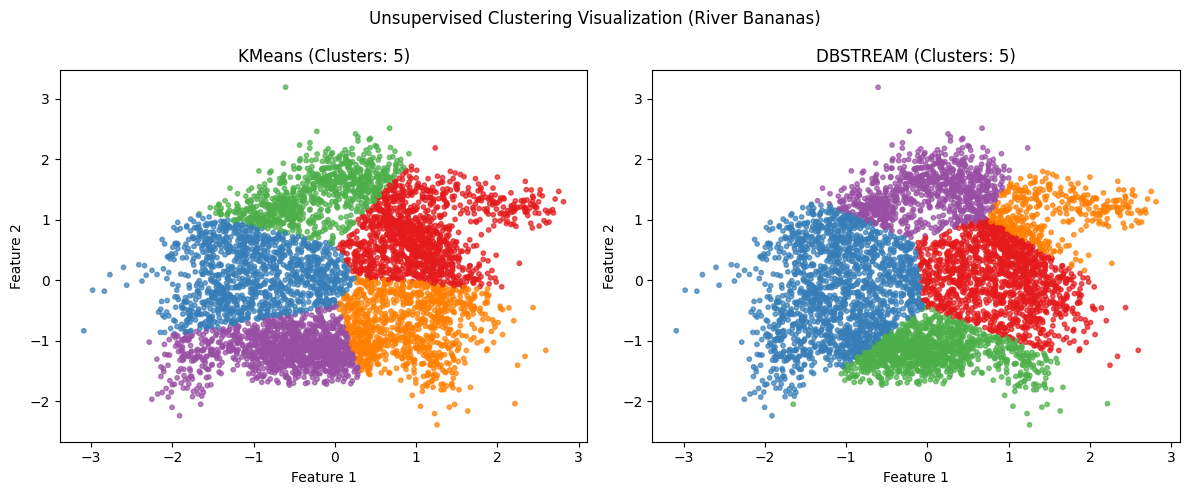

In [150]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

data = datasets.Bananas()

X, y_true = [], []
for x, y in data:
    X.append(list(x.values()))
    y_true.append(y)

X = np.array(X)
y_true = np.array(y_true)

models = {
    "KMeans": preprocessing.StandardScaler() | cluster.KMeans(halflife=0.4),
    "DBSTREAM": preprocessing.StandardScaler() | cluster.DBSTREAM(),
}


for name, model in models.items():
    print(f"\n=== Training {name} ===")
    for xi in X:
        features = {f"x{i}": xi[i] for i in range(len(xi))}
        model.learn_one(features)  


def get_cluster_labels(model, X):
    labels = []
    for xi in X:
        features = {f"x{i}": xi[i] for i in range(len(xi))}
        pred = model.predict_one(features)
        labels.append(pred if pred is not None else -1)
    return np.array(labels)

results = {}

for name, model in models.items():
    labels = get_cluster_labels(model, X)
    mask = labels != -1

    if len(set(labels[mask])) > 1:
        sil = silhouette_score(X[mask], labels[mask])
        ch = calinski_harabasz_score(X[mask], labels[mask])
        db = davies_bouldin_score(X[mask], labels[mask])
    else:
        sil, ch, db = np.nan, np.nan, np.nan

    results[name] = (sil, ch, db, len(set(labels[mask])))


print("\n=== CLUSTER SEPARABILITY METRICS (Bananas) ===")
print(f"{'Model':15s} {'Silhouette':>12s} {'CH-Index':>12s} {'DB-Index':>12s} {'#Clusters':>12s}")
print("-"*60)
for name, (sil, ch, db, n_clusters) in results.items():
    print(f"{name:15s} {sil:12.4f} {ch:12.4f} {db:12.4f} {n_clusters:12d}")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
for ax, (name, model) in zip(axes, models.items()):
    labels = get_cluster_labels(model, X)
    mask = labels != -1
    colors = np.array(["#377eb8", "#e41a1c", "#4daf4a", "#984ea3", "#ff7f00" ])
    ax.scatter(X[mask, 0], X[mask, 1], c=colors[labels[mask] % len(colors)], s=10, alpha=0.7)
    ax.set_title(f"{name} (Clusters: {len(set(labels[mask]))})")
    ax.set_xlabel("Feature 1")
    ax.set_ylabel("Feature 2")

plt.suptitle("Unsupervised Clustering Visualization (River Bananas)")
plt.tight_layout()
plt.show()


### 3. Anomaly Detection with Phishing DATASET:

In [151]:
data = datasets.Phishing()

models = {
    "HalfSpaceTrees": preprocessing.StandardScaler() | anomaly.HalfSpaceTrees(seed=42),
    "OneClassSVM": preprocessing.StandardScaler() | anomaly.OneClassSVM(nu=0.05),
}

acc   = {n: metrics.Accuracy()   for n in models}
prec  = {n: metrics.Precision()  for n in models}
rec   = {n: metrics.Recall()     for n in models}
f1    = {n: metrics.F1()         for n in models}
mcc   = {n: metrics.MCC()        for n in models}
kappa = {n: metrics.CohenKappa() for n in models}
roc   = {n: metrics.ROCAUC()     for n in models}
MAX_SAMPLES = 20000
PRINT_EVERY = 2000

n = 0
t0 = time.time()

score_history = {name: [] for name in models}
THRESHOLD_PERCENTILE = 95

for x, y in data:
    n += 1
    y_true = 1 if y else 0

    for name, model in models.items():
        score = model.score_one(x)
        score_history[name].append(score)

        if len(score_history[name]) > 100:
            threshold = np.percentile(score_history[name], THRESHOLD_PERCENTILE)
        else:
            threshold = np.percentile(score_history[name], 50) 

        y_pred = 1 if score > threshold else 0

        acc[name].update(y_true, y_pred)
        prec[name].update(y_true, y_pred)
        rec[name].update(y_true, y_pred)
        f1[name].update(y_true, y_pred)
        mcc[name].update(y_true, y_pred)
        kappa[name].update(y_true, y_pred)
        roc[name].update(y_true, y_pred)

        model.learn_one(x)

    if n % PRINT_EVERY == 0:
        dt = time.time() - t0
        print(f"Processed {n} samples in {dt:.1f}s (~{n/dt:.1f} samples/s)")

    if MAX_SAMPLES and n >= MAX_SAMPLES:
        break

print("\n=== FINAL RESULTS (Adaptive Anomaly Detection on Phishing) ===")
print(f"{'Model':20s} {'Acc':>8s} {'Prec':>8s} {'Rec':>8s} {'F1':>8s} {'MCC':>8s} {'Kappa':>8s} {'ROC AUC':>8s}")
print("-" * 90)

for name in models:
    print(f"{name:20s} "
          f"{acc[name].get():8.4f} "
          f"{prec[name].get():8.4f} "
          f"{rec[name].get():8.4f} "
          f"{f1[name].get():8.4f} "
          f"{mcc[name].get():8.4f} "
          f"{kappa[name].get():8.4f} "
          f"{roc[name].get():8.4f}")



=== FINAL RESULTS (Adaptive Anomaly Detection on Phishing) ===
Model                     Acc     Prec      Rec       F1      MCC    Kappa  ROC AUC
------------------------------------------------------------------------------------------
HalfSpaceTrees         0.5120   0.2328   0.0493   0.0813  -0.1326  -0.0848   0.4612
OneClassSVM            0.5608   0.4947   0.0858   0.1462   0.0326   0.0191   0.5087


# Part II: Capy Moa:

### 1. Supervised Learning with Electricity Dataset:

In [152]:
from capymoa.datasets import Electricity
from capymoa.evaluation import ClassificationWindowedEvaluator, ClassificationEvaluator
from capymoa.classifier import HoeffdingTree, NaiveBayes
from sklearn.metrics import roc_auc_score
WINDOW_SIZE   = 4500
MAX_INSTANCES = 50000
POS_INDEX     = 1

stream = Electricity()
schema = stream.get_schema()

models = {
    "HoeffdingTree": HoeffdingTree(schema=schema),
    "NaiveBayes": NaiveBayes(schema=schema),
}

windowed = {
    name: ClassificationWindowedEvaluator(schema=schema, window_size=WINDOW_SIZE)
    for name in models
}
cumulative = {
    name: ClassificationEvaluator(schema=schema, window_size=WINDOW_SIZE)
    for name in models
}

class BinaryMetrics:
    def __init__(self):
        self.tp = self.fp = self.tn = self.fn = 0
        self.y_true_list, self.y_score_list = [], []

    def update(self, y_true, y_score, threshold=0.5, pos=1):
        y_pred = 1 if y_score > threshold else 0
        if y_true == pos:
            if y_pred == pos: self.tp += 1
            else: self.fn += 1
        else:
            if y_pred == pos: self.fp += 1
            else: self.tn += 1
        self.y_true_list.append(y_true)
        self.y_score_list.append(y_score)

    def accuracy(self):
        n = self.tp + self.fp + self.tn + self.fn
        return (self.tp + self.tn) / n if n else 0

    def precision(self):
        d = (self.tp + self.fp)
        return self.tp / d if d else 0

    def recall(self):
        d = (self.tp + self.fn)
        return self.tp / d if d else 0

    def f1(self):
        p, r = self.precision(), self.recall()
        return 2*p*r/(p+r) if (p+r) else 0

    def mcc(self):
        num = (self.tp*self.tn) - (self.fp*self.fn)
        den = ((self.tp+self.fp)*(self.tp+self.fn)*(self.tn+self.fp)*(self.tn+self.fn)) ** 0.5
        return num/den if den else 0

    def kappa(self):
        n = self.tp + self.fp + self.tn + self.fn
        acc = self.accuracy()
        pe = ((self.tp+self.fn)*(self.tp+self.fp) + (self.fp+self.tn)*(self.fn+self.tn)) / (n*n)
        return (acc - pe)/(1 - pe) if (1 - pe) else 0

    def roc_auc(self):
        if len(set(self.y_true_list)) < 2:
            return 0.5
        try:
            return roc_auc_score(self.y_true_list, self.y_score_list)
        except Exception:
            return 0.5

bin_metrics = {name: BinaryMetrics() for name in models}

i = 0
while stream.has_more_instances():
    inst = stream.next_instance()
    y_true = inst.y_index

    for name, clf in models.items():
        y_pred = clf.predict(inst)
        windowed[name].update(y_true, y_pred)
        cumulative[name].update(y_true, y_pred)
        bin_metrics[name].update(y_true, y_pred, pos=POS_INDEX)
        clf.train(inst)

    i += 1
    if MAX_INSTANCES is not None and i >= MAX_INSTANCES:
        break

print("\n[Cumulative binary metrics]")
print("\n[Cumulative binary metrics]")
print(f"{'Model':15s}  {'Acc':>7s}  {'F1':>7s}  {'Prec':>7s}  {'Rec':>7s}  {'MCC':>7s}  {'Kappa':>7s}  {'ROC AUC':>7s}")
print("-" * 78)

for name in models:
    m = bin_metrics[name]
    print(f"{name:15s}  {m.accuracy():7.4f}  {m.f1():7.4f}  {m.precision():7.4f}  "
          f"{m.recall():7.4f}  {m.mcc():7.4f}  {m.kappa():7.4f}  {m.roc_auc():7.4f}")



[Cumulative binary metrics]

[Cumulative binary metrics]
Model                Acc       F1     Prec      Rec      MCC    Kappa  ROC AUC
------------------------------------------------------------------------------
HoeffdingTree     0.8173   0.8425   0.8359   0.8492   0.6251   0.6250   0.8116
NaiveBayes        0.7336   0.7977   0.7085   0.9126   0.4555   0.4254   0.7018


### 2. Anomaly detection on ElectricityTiny Dataset:

In [153]:
from capymoa.datasets import ElectricityTiny
from capymoa.anomaly import HalfSpaceTrees, StreamRHF
from sklearn.metrics import roc_auc_score

MAX_INSTANCES = 10000
POS_INDEX = 1

stream = ElectricityTiny()
schema = stream.get_schema()

models = {
    "HalfSpaceTrees": HalfSpaceTrees(schema=schema, window_size=250, number_of_trees=25),
    "StreamRHF": StreamRHF(schema=schema, num_trees=5, max_height=3)
}

metrics = {name: BinaryMetrics() for name in models}

i = 0
while stream.has_more_instances():
    inst = stream.next_instance()
    y_true = inst.y_index  # Binary (0 or 1)

    for name, model in models.items():
        score = model.score_instance(inst)
        model.train(inst)
        metrics[name].update(y_true, score)

    i += 1
    if i >= MAX_INSTANCES:
        break

print("\n=== ANOMALY DETECTION RESULTS (Electricity Dataset) ===")
print(f"{'Model':25s} {'Acc':>8s} {'F1':>8s} {'Prec':>8s} {'Rec':>8s} {'MCC':>8s} {'Kappa':>8s} {'ROC AUC':>8s}")
print("-"*88)

for name, m in metrics.items():
    print(f"{name:25s} {m.accuracy():8.4f} {m.f1():8.4f} {m.precision():8.4f} "
          f"{m.recall():8.4f} {m.mcc():8.4f} {m.kappa():8.4f} {m.roc_auc():8.4f}")



=== ANOMALY DETECTION RESULTS (Electricity Dataset) ===
Model                          Acc       F1     Prec      Rec      MCC    Kappa  ROC AUC
----------------------------------------------------------------------------------------
HalfSpaceTrees              0.5945   0.2057   0.4585   0.1326   0.0460   0.0341   0.5615
StreamRHF                   0.5460   0.6052   0.4615   0.8788   0.2346   0.1788   0.7277
